## Stein kernel thinning on a mixture of gaussians

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import time

from goodpoints.jax.autotune import autotune
from goodpoints.jax.kernel.scalar import imq
from goodpoints.jax.kernel.precond_stein import PrecondSteinKernel
from goodpoints.jax.dtc import skt
from goodpoints.jax.mmd import compute_mmd
from goodpoints.jax.distribution import Gaussian, Mixture

jax.config.update('jax_enable_x64', True) # enforce 64-bit floating precision

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# Setting up input distribution and input points.

rng_gen = np.random.default_rng(42)
rng = jax.random.PRNGKey(rng_gen.integers(2**31))
n = 2**16
out_size = 2**8

cov_sqrt1 = rng_gen.normal(size=(2, 2))
cov_sqrt2 = rng_gen.normal(size=(2, 2))
dist1 = Gaussian(np.array([0, 0.5]), 
                cov_sqrt1)
dist2 = Gaussian(np.array([0, 0.5]), 
                cov_sqrt2)
mixture = Mixture([dist1, dist2], weights=np.array([0.5, 0.5]))

rng, p_rng = jax.random.split(rng)
p, choices = mixture.sample_with_choices(p_rng, n)
s = jax.vmap(dist1.score)(p)
hess_fn = jax.jacfwd(dist1.score)

INFO:2024-12-09 00:18:57,308:jax._src.xla_bridge:927: Unable to initialize backend 'cuda': 
2024-12-09 00:18:57,308 - INFO - Unable to initialize backend 'cuda': 
INFO:2024-12-09 00:18:57,310:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-09 00:18:57,310 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2024-12-09 00:18:57,312:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-09 00:18:57,312 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-09 00:18:57,312 - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
# Create the mean-zero kernel using automatic tuning heuristics.

tuned_params = autotune(p, scores=s,
                        hess_fn=hess_fn)
kernel = PrecondSteinKernel(imq, 
                            M=tuned_params['M'],
                            med_sqr=tuned_params['med_sqr'])
points = kernel.prepare_input(p, s)

In [ ]:
w_thin, supp = skt(kernel, points, out_size)
start_time = time.time()
print(f'Elapsed: {time.time() - start_time}s')

2024-12-09 00:21:07,676 - INFO - KT splitting with 65536 points and thinning to 256 points...
2024-12-09 00:24:31,527 - INFO - KT-swap improvement...


Elapsed: 5.698204040527344e-05s


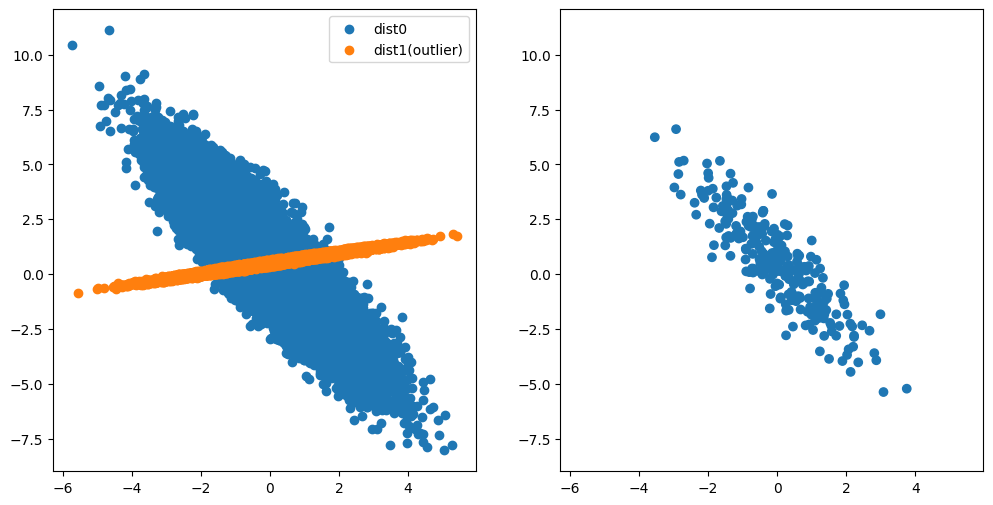

In [7]:
import matplotlib.pyplot as plt

def plot():
    figsize = 6
    fig, axes = plt.subplots(1, 2, figsize=(figsize*2,figsize))
    axes[0].scatter(p[choices==0, 0], p[choices==0, 1], label='dist0')
    axes[0].scatter(p[choices==1, 0], p[choices==1, 1], label='dist1(outlier)')
    axes[0].legend()
    axes[1].scatter(p[:, 0], p[:, 1], alpha=np.minimum(1, w_thin * n))
    plt.setp(axes, xlim=axes[0].get_xlim(), ylim=axes[0].get_ylim())
plot()

In [8]:
mmd_P = compute_mmd(kernel, points.subset(supp), w1=w_thin[supp], mode='mean-zero')
print(f'MMD to P: {mmd_P}')

MMD to P: 2.587793902863337e-05
